<a href="https://colab.research.google.com/github/anushahulbatte/deeplearning/blob/main/Task1_a_validationset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

if torch.__version__ != '2.5.1+cu124':
    !pip install torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu124 -U --quiet
    print("PyTorch version updated to 2.5.1.")
else:
    print("PyTorch is already at the correct version (2.5.1).")

PyTorch is already at the correct version (2.5.1).


In [2]:
!pip install d2l==1.0.3 --quiet
!pip install scipy --quiet
!pip install torchmetrics --quiet

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import RandomSampler, random_split

from tqdm.auto import tqdm, trange
from matplotlib import pyplot as plt

DEVICE = torch.device("cpu")

In [4]:
import random
import os
import matplotlib.pyplot as plt
import csv
import numpy as np

In [5]:
import os
! git clone https://git.wur.nl/bioinformatics/grs34806-deep-learning-project-data.git
os.chdir("grs34806-deep-learning-project-data")

fatal: destination path 'grs34806-deep-learning-project-data' already exists and is not an empty directory.


Writing a function to read the simulated data and produce lists containing the sequences and a list of 0s and 1s.

In [6]:
def read(seqfile, posfile):
  """
  Extracting the sequences from the seqfile and creating a list called datalist.
  Making a list called labellist containing 0s and 1s, where 1 denotes the
  sequence identifiers in the posfile.
  """
  # Removing the sequence identifiers
  with open(seqfile, 'r') as f:
    seq_lines = [seq_lines.strip() for seq_lines in f.readlines() if seq_lines.strip()]
    #print(seq_lines)
  seq_ids = []
  datalist = []
  current_seq = ""
  for line in seq_lines:
    if line.startswith("seq"):
      parts = line.split()
      #print(parts)
      seq_ids.append(parts[0])
      datalist.append(parts[1])

  with open(posfile, 'r') as f:
    annotated_ids = [line.strip() for line in f.readlines() if line.strip()]
    #print(annotated_ids)
  labellist = [1 if seq_id in annotated_ids else 0 for seq_id in seq_ids]

  #print("Length of the datalist: ", len(datalist))
  #print("Length of labellist: ", len(labellist))
  #print("The number of positives in labellist: ", sum(labellist))
  #for i in range(min(5, len(datalist))):
        #print(f"ID: {seq_ids[i]}, Has annotation: {labellist[i]}, Sequence length: {len(datalist[i])}")

  return datalist, labellist

In [7]:
datalist, labellist = read(seqfile = "/content/grs34806-deep-learning-project-data/len100_200_n1000.seq",
posfile = "/content/grs34806-deep-learning-project-data/len100_200_n1000.pos")

Splitting the dataset into a training, validation and test set.

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

def generate_train_val_test(datalist, labellist, test_size=0.2, val_size=0.25,
                            random_state=42):
  """
  First splitting the data into training and testing sets.
  And then separating the training set into a validation set.
  This is done in a 60%, 20% and 20% manner.
  """
  trainval_data, test_data, trainval_labels, test_labels = train_test_split(
      datalist, labellist, test_size=test_size,
      random_state = random_state
  )

  train_data, val_data, train_labels, val_labels = train_test_split(
      trainval_data, trainval_labels, test_size=val_size,
      random_state=random_state
  )

  return train_data, val_data, test_data, train_labels, val_labels, test_labels

In [9]:
train_data, val_data, test_data, train_labels, val_labels, test_labels = generate_train_val_test(
    datalist, labellist
)

In [10]:
print("Training data size:", len(train_data))
print("Training labels size:", len(train_labels))
print("Validation data size: ", len(val_data))
print("Validation labels size: ", len(val_labels))
print("Test data size:", len(test_data))
print("Test labels size:", len(test_labels))

Training data size: 600
Training labels size: 600
Validation data size:  200
Validation labels size:  200
Test data size: 200
Test labels size: 200


Defining the provided functions

In [11]:
def tokenize(dat, map2num, non_aa_num=20):
  """
  This function takes in the sequences of AA. It uses dictionary mapping, to map
  AA to integers. The non_aa_num make up the unknown AA, and its default value is
  20.
  """
  seq = []
  for count, i in enumerate(dat):
      seq.append([map2num.get(j, non_aa_num) for j in list(i)])
  return seq

In [12]:
def build_seq_array(lines, num_steps, non_aa_num=20):
  """
  This function applies the truncate_pad function to all the sequences.
  It then converts the sequences into tensors.
  """
  array = torch.tensor([
      truncate_pad(l, num_steps, non_aa_num) for l in lines])
  return array

In [13]:
def truncate_pad(line, num_steps, padding_token):
  """
  The line in the parameters refers to the tokenized sequence.
  num_steps is the maxmimum sequence length. The padding_token is the integer
  for padding.
  The function pads shorter sequences with padding_token.
  """
  if len(line) > num_steps:
    return line[:num_steps] #Truncate
  return line + [padding_token] * (num_steps - len(line))

In [14]:
from d2l import torch as d2l

Function load_data including code for converting the tokenised sequence into 1-hot encoded representation so it can be fed as input to the CNN.

In [15]:
def load_data(batch_size, num_steps, dataset, trainlabels = None):
  mapaa2num = {aa: i for (i, aa)
                      in enumerate(list("ACDEFGHIKLMNPQRSTVWY"))}
  # Creating a dictionary which maps each AA to a unique integer
  seq, lab = dataset, trainlabels # lab is the labels which are associated with sequences

  seq = tokenize(seq, mapaa2num)
  seq_array = build_seq_array(seq, num_steps) # Shape = batch_size, num_steps

  # To convert the sequences to one-hot encoding
  # one_hot method takes a tensor and returns a tensor of shape of num_classes
  vocab_size = len(mapaa2num)
  seq_onehotencoding = F.one_hot(seq_array, num_classes=vocab_size).float()
  seq_onehotencoding = seq_onehotencoding.permute(0,2,1)
  # Shape = batch_size, vocab_size, num_steps

  data_arrays = (seq_onehotencoding, torch.tensor(lab))
  #data_arrays = (seq_array, torch.tensor(lab))
  data_iter = d2l.load_array(data_arrays, batch_size)
  #print("Shape of seq_array: ", seq_array.shape)
  #print("Shape of data_arrays, which now considers \none-hot encoded sequence: ",
        #seq_onehotencoding.shape)
  return data_iter

In [16]:
print("Unique labels:", torch.unique(torch.tensor(train_labels)))

Unique labels: tensor([0, 1])


In [17]:
train_iter = load_data(batch_size = 25, num_steps=100, dataset=train_data, trainlabels=train_labels)
validation_iter = load_data(batch_size=25, num_steps=100, dataset=val_data, trainlabels=val_labels)
test_iter = load_data(batch_size= 25, num_steps = 100, dataset = test_data, trainlabels = test_labels)

Building the CNN

In [18]:
class ProteinCNN1D(nn.Module):
  def __init__(self, vocab_size:int, context_size:int, conv_channels:int=512,
                use_bias:bool=False, dropout_rate = 0.5, lr = 1, weight_decay=1e-4,
               momentum = 0):
      super().__init__()
      assert context_size % 2 == 0, f'Invalid block_size, {context_size} is not an even number'
      self.vocab_size = vocab_size
      self.context_size = context_size
      self.momentum = momentum
      self.cnn = nn.Sequential(
          nn.Conv1d(in_channels=self.vocab_size,
                    out_channels=conv_channels,
                    kernel_size=3,
                    padding='same',
                    bias=use_bias),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.Conv1d(in_channels=conv_channels,
                    out_channels=256,
                    kernel_size = 3,
                    padding = 'same',
                    bias = use_bias),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.Conv1d(in_channels=256,
                    out_channels=128,
                    kernel_size = 3,
                    padding = 'same',
                    bias = use_bias),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.Flatten(),
          nn.Linear(in_features = int(128*(self.context_size//8)),
                    out_features = 256,
                    bias = use_bias),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.Linear(in_features = 256,
                    out_features = 1,
                    bias = use_bias)

      )
  def forward(self, X:torch.tensor, targets: torch.tensor=None) -> tuple[torch.tensor, torch.tensor]:
    logits = self.cnn(X).squeeze(1)
    loss = None if targets is None else F.binary_cross_entropy_with_logits(
        logits, targets.float())
    return logits, loss



Trying the model with:

*   Batch size = 32
*   Context_size = 100
*   Learning_tate = 1e-3
*   Dropout_rate = 0.5
*   Num_epochs = 20

Implementing early stopping using the validation set to prevent overfitting of the model on the data.



In [19]:
batch_size = 32
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4
best_loss =float('inf')


train_iter = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=train_data,
                       trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                            num_steps=context_size,
                            dataset = val_data,
                            trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = test_data,
                      trainlabels = test_labels)

# Initializing the model
model = ProteinCNN1D(
    vocab_size=20,
    context_size=context_size,
    conv_channels=512,
    use_bias = False,
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate,
                              weight_decay=weight_decay)

best_val_acc = 0.0
no_improve = 0
patience = 5 #This defines the number of epochs to wait before stopping
min_delta = 0.001 #The minimum amount of improvement to count as progress

train_losses = []
val_accuracies = []
test_accuracies=[]

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for X, y in validation_iter:
          X, y = X.to(DEVICE), y.to(DEVICE)
          logits, _ = model(X, y) #Looking at accuracy only
          val_loss += loss.item()
          preds = (torch.sigmoid(logits) > 0.5).float()
          val_correct += (preds == y).sum().item()
          val_total += y.size(0)

  current_val_acc= val_correct/val_total
  val_accuracies.append(current_val_acc)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]:.4f}')

  # Early stopping check
  if current_val_acc > best_val_acc+min_delta:
      best_val_acc = current_val_acc
      no_improve = 0
      torch.save(model.state_dict(), 'best_model.pth')  # Save best model
  else:
      no_improve += 1
      if no_improve >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}")
          model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Restore best model
          break

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, _ = model(X, y)
        preds = (torch.sigmoid(logits) > 0.5).float()
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

final_test_acc = test_correct / test_total
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

Epoch 1: Train Loss: 0.7009, Validation Accuracy: 0.4750
Epoch 2: Train Loss: 0.6892, Validation Accuracy: 0.4750
Epoch 3: Train Loss: 0.6958, Validation Accuracy: 0.4750
Epoch 4: Train Loss: 0.6949, Validation Accuracy: 0.4750
Epoch 5: Train Loss: 0.6917, Validation Accuracy: 0.5250
Epoch 6: Train Loss: 0.6865, Validation Accuracy: 0.7250
Epoch 7: Train Loss: 0.5865, Validation Accuracy: 0.7650
Epoch 8: Train Loss: 0.4364, Validation Accuracy: 0.8100
Epoch 9: Train Loss: 0.3685, Validation Accuracy: 0.8250
Epoch 10: Train Loss: 0.3657, Validation Accuracy: 0.8200

Final Test Accuracy: 0.8600


Testing the model on the test data using 17 epochs which was returned using early stopping

Epoch 1: Train Loss: 0.7003, Val Loss: 0.6935, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 2: Train Loss: 0.6929, Val Loss: 0.6931, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 3: Train Loss: 0.6966, Val Loss: 0.6931, Val Acc: 0.4850, Test Acc: 0.4650
Epoch 4: Train Loss: 0.6948, Val Loss: 0.6930, Val Acc: 0.5750, Test Acc: 0.6250
Epoch 5: Train Loss: 0.6938, Val Loss: 0.6929, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 6: Train Loss: 0.6925, Val Loss: 0.6893, Val Acc: 0.5250, Test Acc: 0.5300
Epoch 7: Train Loss: 0.6905, Val Loss: 0.6890, Val Acc: 0.5550, Test Acc: 0.5550
Epoch 8: Train Loss: 0.6399, Val Loss: 0.5980, Val Acc: 0.6350, Test Acc: 0.6150
Epoch 9: Train Loss: 0.4356, Val Loss: 0.4084, Val Acc: 0.8150, Test Acc: 0.8600
Epoch 10: Train Loss: 0.3925, Val Loss: 0.3880, Val Acc: 0.8150, Test Acc: 0.8650


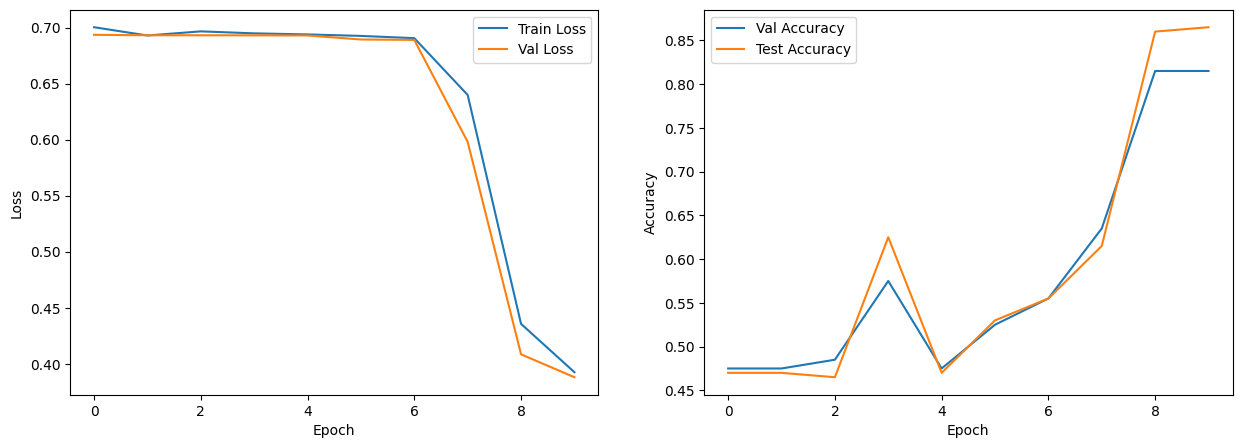

In [20]:
batch_size = 32
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4

# Load all datasets
train_iter = load_data(batch_size=batch_size,
                      num_steps=context_size,
                      dataset=train_data,
                      trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                          num_steps=context_size,
                          dataset=val_data,
                          trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                     num_steps=context_size,
                     dataset=test_data,
                     trainlabels=test_labels)

# Initialize model
model = ProteinCNN1D(
    vocab_size=20,
    context_size=context_size,
    conv_channels=512,
    use_bias=False
)
model.to(DEVICE)

# Optimizer
optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    for X, y in train_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_losses.append(epoch_train_loss / len(train_iter))
    train_accuracy = train_correct / train_total

    # Validation evaluation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in validation_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            val_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(validation_iter))
    val_accuracies.append(val_correct / val_total)

    # Test evaluation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_losses.append(test_loss / len(test_iter))
    test_accuracies.append(test_correct / test_total)

    # Print metrics
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1]:.4f}, '
          f'Test Acc: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Implementing the same parameters as before, but with a weight decay value of 0.001

In [21]:
batch_size = 32
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 0.001
best_loss =float('inf')


train_iter = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=train_data,
                       trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                            num_steps=context_size,
                            dataset = val_data,
                            trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = test_data,
                      trainlabels = test_labels)

# Initializing the model
model = ProteinCNN1D(
    vocab_size=20,
    context_size=context_size,
    conv_channels=512,
    use_bias = False,
    weight_decay = weight_decay
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate,
                              weight_decay=weight_decay)

best_val_acc = 0.0
no_improve = 0
patience = 5 #This defines the number of epochs to wait before stopping
min_delta = 0.001 #The minimum amount of improvement to count as progress

train_losses = []
val_accuracies = []
test_accuracies=[]

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for X, y in validation_iter:
          X, y = X.to(DEVICE), y.to(DEVICE)
          logits, _ = model(X, y) #Looking at accuracy only
          val_loss += loss.item()
          preds = (torch.sigmoid(logits) > 0.5).float()
          val_correct += (preds == y).sum().item()
          val_total += y.size(0)

  current_val_acc= val_correct/val_total
  val_accuracies.append(current_val_acc)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]:.4f}')

  # Early stopping check
  if current_val_acc > best_val_acc+min_delta:
      best_val_acc = current_val_acc
      no_improve = 0
      torch.save(model.state_dict(), 'best_model.pth')  # Save best model
  else:
      no_improve += 1
      if no_improve >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}")
          model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Restore best model
          break

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, _ = model(X, y)
        preds = (torch.sigmoid(logits) > 0.5).float()
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

final_test_acc = test_correct / test_total
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

Epoch 1: Train Loss: 0.6978, Validation Accuracy: 0.4700
Epoch 2: Train Loss: 0.6971, Validation Accuracy: 0.5250
Epoch 3: Train Loss: 0.6927, Validation Accuracy: 0.5350
Epoch 4: Train Loss: 0.6917, Validation Accuracy: 0.4750
Epoch 5: Train Loss: 0.6898, Validation Accuracy: 0.6600
Epoch 6: Train Loss: 0.6217, Validation Accuracy: 0.7200
Epoch 7: Train Loss: 0.4490, Validation Accuracy: 0.8150
Epoch 8: Train Loss: 0.4014, Validation Accuracy: 0.8100
Epoch 9: Train Loss: 0.3753, Validation Accuracy: 0.8150
Epoch 10: Train Loss: 0.3526, Validation Accuracy: 0.8150

Final Test Accuracy: 0.8650


Epoch 1: Train Loss: 0.7033, Val Loss: 0.6933, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 2: Train Loss: 0.6942, Val Loss: 0.6925, Val Acc: 0.5250, Test Acc: 0.5300
Epoch 3: Train Loss: 0.6949, Val Loss: 0.6933, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 4: Train Loss: 0.6933, Val Loss: 0.6932, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 5: Train Loss: 0.6918, Val Loss: 0.6908, Val Acc: 0.7450, Test Acc: 0.7750
Epoch 6: Train Loss: 0.6864, Val Loss: 0.6742, Val Acc: 0.5300, Test Acc: 0.5300
Epoch 7: Train Loss: 0.5556, Val Loss: 0.4622, Val Acc: 0.7950, Test Acc: 0.8550
Epoch 8: Train Loss: 0.4038, Val Loss: 0.4307, Val Acc: 0.8150, Test Acc: 0.8600
Epoch 9: Train Loss: 0.3725, Val Loss: 0.3926, Val Acc: 0.8200, Test Acc: 0.8650
Epoch 10: Train Loss: 0.3562, Val Loss: 0.4145, Val Acc: 0.8200, Test Acc: 0.8450


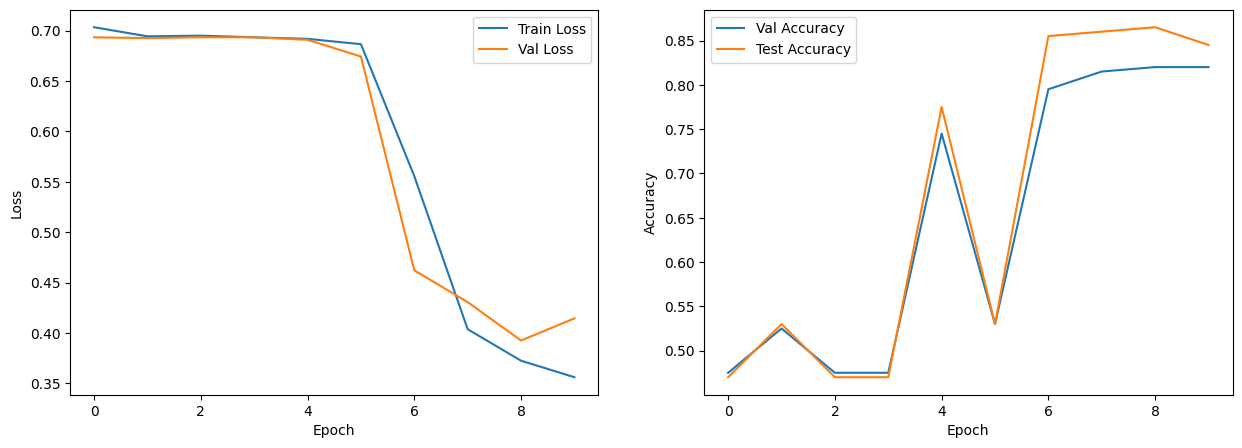

In [22]:
batch_size = 32
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 0.001

# Load all datasets
train_iter = load_data(batch_size=batch_size,
                      num_steps=context_size,
                      dataset=train_data,
                      trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                          num_steps=context_size,
                          dataset=val_data,
                          trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                     num_steps=context_size,
                     dataset=test_data,
                     trainlabels=test_labels)

# Initialize model
model = ProteinCNN1D(
    vocab_size=20,
    context_size=context_size,
    conv_channels=512,
    use_bias=False
)
model.to(DEVICE)

# Optimizer
optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    for X, y in train_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_losses.append(epoch_train_loss / len(train_iter))
    train_accuracy = train_correct / train_total

    # Validation evaluation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in validation_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            val_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(validation_iter))
    val_accuracies.append(val_correct / val_total)

    # Test evaluation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_losses.append(test_loss / len(test_iter))
    test_accuracies.append(test_correct / test_total)

    # Print metrics
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1]:.4f}, '
          f'Test Acc: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Implementing momentum to test performance of the model using SGD optimizer.

In [23]:
batch_size = 32
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4
momentum = 0.5
best_loss =float('inf')


train_iter = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=train_data,
                       trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                            num_steps=context_size,
                            dataset = val_data,
                            trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = test_data,
                      trainlabels = test_labels)

# Initializing the model
model = ProteinCNN1D(
    vocab_size=20,
    context_size=context_size,
    conv_channels=512,
    use_bias = False,
)
model.to(DEVICE)

# Using SGD as the optimizer
optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate,
                              weight_decay=weight_decay, momentum=momentum)

best_val_acc = 0.0
no_improve = 0
patience = 5 #This defines the number of epochs to wait before stopping
min_delta = 0.001 #The minimum amount of improvement to count as progress

train_losses = []
val_accuracies = []
test_accuracies=[]

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for X, y in validation_iter:
          X, y = X.to(DEVICE), y.to(DEVICE)
          logits, _ = model(X, y) #Looking at accuracy only
          val_loss += loss.item()
          preds = (torch.sigmoid(logits) > 0.5).float()
          val_correct += (preds == y).sum().item()
          val_total += y.size(0)

  current_val_acc= val_correct/val_total
  val_accuracies.append(current_val_acc)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]:.4f}')

  # Early stopping check
  if current_val_acc > best_val_acc+min_delta:
      best_val_acc = current_val_acc
      no_improve = 0
      torch.save(model.state_dict(), 'best_model.pth')  # Save best model
  else:
      no_improve += 1
      if no_improve >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}")
          model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Restore best model
          break

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, _ = model(X, y)
        preds = (torch.sigmoid(logits) > 0.5).float()
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

final_test_acc = test_correct / test_total
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

Epoch 1: Train Loss: 0.6930, Validation Accuracy: 0.5250
Epoch 2: Train Loss: 0.6936, Validation Accuracy: 0.5250
Epoch 3: Train Loss: 0.6928, Validation Accuracy: 0.5250
Epoch 4: Train Loss: 0.6944, Validation Accuracy: 0.5300
Epoch 5: Train Loss: 0.6945, Validation Accuracy: 0.5300
Epoch 6: Train Loss: 0.6918, Validation Accuracy: 0.5250
Epoch 7: Train Loss: 0.6939, Validation Accuracy: 0.5250
Epoch 8: Train Loss: 0.6926, Validation Accuracy: 0.5200
Epoch 9: Train Loss: 0.6926, Validation Accuracy: 0.5400
Epoch 10: Train Loss: 0.6944, Validation Accuracy: 0.5550

Final Test Accuracy: 0.5200


Epoch 1: Train Loss: 0.6939, Val Loss: 0.6930, Val Acc: 0.5350, Test Acc: 0.5200
Epoch 2: Train Loss: 0.6932, Val Loss: 0.6930, Val Acc: 0.5350, Test Acc: 0.5050
Epoch 3: Train Loss: 0.6944, Val Loss: 0.6931, Val Acc: 0.5400, Test Acc: 0.5000
Epoch 4: Train Loss: 0.6932, Val Loss: 0.6929, Val Acc: 0.5500, Test Acc: 0.5000
Epoch 5: Train Loss: 0.6931, Val Loss: 0.6931, Val Acc: 0.5300, Test Acc: 0.5150
Epoch 6: Train Loss: 0.6933, Val Loss: 0.6930, Val Acc: 0.5350, Test Acc: 0.5000
Epoch 7: Train Loss: 0.6926, Val Loss: 0.6931, Val Acc: 0.5400, Test Acc: 0.5050
Epoch 8: Train Loss: 0.6934, Val Loss: 0.6929, Val Acc: 0.5350, Test Acc: 0.5000
Epoch 9: Train Loss: 0.6931, Val Loss: 0.6930, Val Acc: 0.5350, Test Acc: 0.5000
Epoch 10: Train Loss: 0.6934, Val Loss: 0.6930, Val Acc: 0.5150, Test Acc: 0.4850


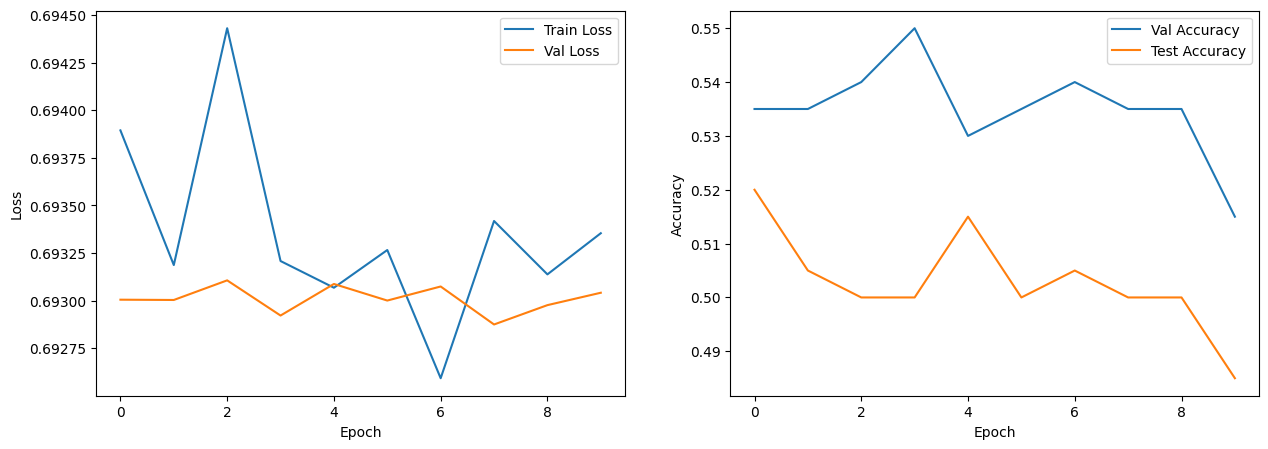

In [24]:
batch_size = 32
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
momentum=0.5
weight_decay = 1e-4

# Load all datasets
train_iter = load_data(batch_size=batch_size,
                      num_steps=context_size,
                      dataset=train_data,
                      trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                          num_steps=context_size,
                          dataset=val_data,
                          trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                     num_steps=context_size,
                     dataset=test_data,
                     trainlabels=test_labels)

# Initialize model
model = ProteinCNN1D(
    vocab_size=20,
    context_size=context_size,
    conv_channels=512,
    use_bias=False
)
model.to(DEVICE)

# Optimizer
optimizer = torch.optim.SGD(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay,
                            momentum=momentum)

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    for X, y in train_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_losses.append(epoch_train_loss / len(train_iter))
    train_accuracy = train_correct / train_total

    # Validation evaluation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in validation_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            val_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(validation_iter))
    val_accuracies.append(val_correct / val_total)

    # Test evaluation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_losses.append(test_loss / len(test_iter))
    test_accuracies.append(test_correct / test_total)

    # Print metrics
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1]:.4f}, '
          f'Test Acc: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Increasing the batch size, going from 32 to 64, and using AdamW optimizer as performance with SGD optimizer was not optimal.

In [25]:
batch_size = 64
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4
best_loss =float('inf')


train_iter = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=train_data,
                       trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                            num_steps=context_size,
                            dataset = val_data,
                            trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = test_data,
                      trainlabels = test_labels)

# Initializing the model
model = ProteinCNN1D(
    vocab_size=20,
    context_size=context_size,
    conv_channels=512,
    use_bias = False,
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate,
                              weight_decay=weight_decay)

best_val_acc = 0.0
no_improve = 0
patience = 5 #This defines the number of epochs to wait before stopping
min_delta = 0.001 #The minimum amount of improvement to count as progress

train_losses = []
val_accuracies = []
test_accuracies=[]

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for X, y in validation_iter:
          X, y = X.to(DEVICE), y.to(DEVICE)
          logits, _ = model(X, y) #Looking at accuracy only
          val_loss += loss.item()
          preds = (torch.sigmoid(logits) > 0.5).float()
          val_correct += (preds == y).sum().item()
          val_total += y.size(0)

  current_val_acc= val_correct/val_total
  val_accuracies.append(current_val_acc)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]:.4f}')

  # Early stopping check
  if current_val_acc > best_val_acc+min_delta:
      best_val_acc = current_val_acc
      no_improve = 0
      torch.save(model.state_dict(), 'best_model.pth')  # Save best model
  else:
      no_improve += 1
      if no_improve >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}")
          model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Restore best model
          break

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, _ = model(X, y)
        preds = (torch.sigmoid(logits) > 0.5).float()
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

final_test_acc = test_correct / test_total
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

Epoch 1: Train Loss: 0.7019, Validation Accuracy: 0.5300
Epoch 2: Train Loss: 0.6952, Validation Accuracy: 0.4750
Epoch 3: Train Loss: 0.6936, Validation Accuracy: 0.4750
Epoch 4: Train Loss: 0.6921, Validation Accuracy: 0.5250
Epoch 5: Train Loss: 0.6954, Validation Accuracy: 0.4750
Epoch 6: Train Loss: 0.6936, Validation Accuracy: 0.4750
Early stopping triggered at epoch 6

Final Test Accuracy: 0.5150


Epoch 1: Train Loss: 0.6973, Val Loss: 0.6955, Val Acc: 0.5250, Test Acc: 0.5300
Epoch 2: Train Loss: 0.6965, Val Loss: 0.6921, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 3: Train Loss: 0.6940, Val Loss: 0.6934, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 4: Train Loss: 0.6929, Val Loss: 0.6930, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 5: Train Loss: 0.6904, Val Loss: 0.6939, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 6: Train Loss: 0.6900, Val Loss: 0.6922, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 7: Train Loss: 0.6747, Val Loss: 0.6640, Val Acc: 0.5250, Test Acc: 0.5300
Epoch 8: Train Loss: 0.6499, Val Loss: 0.6578, Val Acc: 0.5850, Test Acc: 0.5800
Epoch 9: Train Loss: 0.5301, Val Loss: 0.5423, Val Acc: 0.7350, Test Acc: 0.7750
Epoch 10: Train Loss: 0.4221, Val Loss: 0.4447, Val Acc: 0.8100, Test Acc: 0.8600


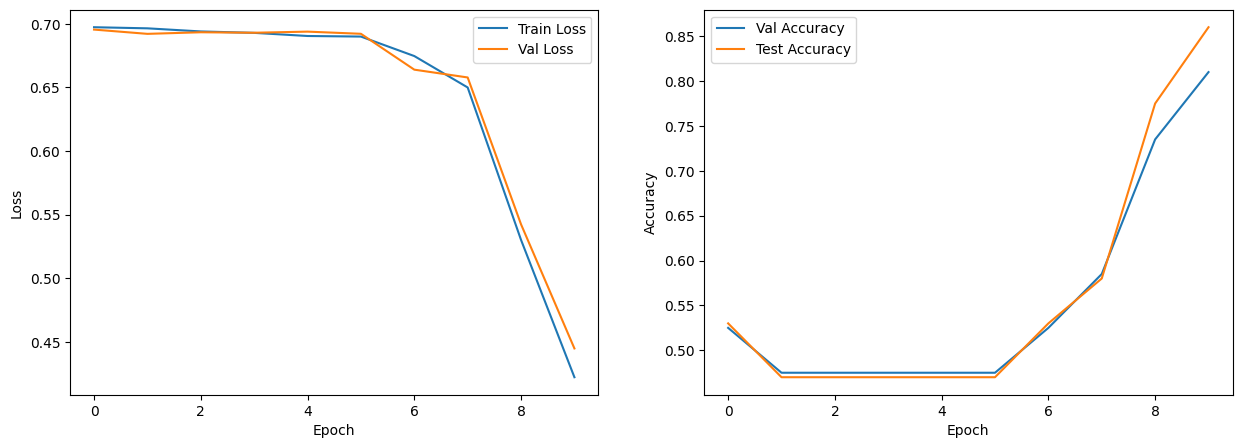

In [26]:
batch_size = 64
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4

# Load all datasets
train_iter = load_data(batch_size=batch_size,
                      num_steps=context_size,
                      dataset=train_data,
                      trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                          num_steps=context_size,
                          dataset=val_data,
                          trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                     num_steps=context_size,
                     dataset=test_data,
                     trainlabels=test_labels)

# Initialize model
model = ProteinCNN1D(
    vocab_size=20,
    context_size=context_size,
    conv_channels=512,
    use_bias=False
)
model.to(DEVICE)

# Optimizer
optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    for X, y in train_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_losses.append(epoch_train_loss / len(train_iter))
    train_accuracy = train_correct / train_total

    # Validation evaluation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in validation_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            val_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(validation_iter))
    val_accuracies.append(val_correct / val_total)

    # Test evaluation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_losses.append(test_loss / len(test_iter))
    test_accuracies.append(test_correct / test_total)

    # Print metrics
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1]:.4f}, '
          f'Test Acc: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Implementing Batch Norm in the architecture to test performance of the model, along with a momentum of 0.5.

In [27]:
class BatchNorm_ProteinCNN1D(nn.Module):
  def __init__(self, vocab_size:int, context_size:int, conv_channels:int=512,
                use_bias:bool=False, dropout_rate = 0.5, lr = 1, weight_decay=1e-4
               ):
      super().__init__()
      assert context_size % 2 == 0, f'Invalid block_size, {context_size} is not an even number'
      self.vocab_size = vocab_size
      self.context_size = context_size
      self.momentum = momentum
      self.cnn = nn.Sequential(
          nn.Conv1d(in_channels=self.vocab_size,
                    out_channels=conv_channels,
                    kernel_size=3,
                    padding='same',
                    bias=use_bias),
          nn.BatchNorm1d(conv_channels),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.Conv1d(in_channels=conv_channels,
                    out_channels=256,
                    kernel_size = 3,
                    padding = 'same',
                    bias = use_bias),
          nn.BatchNorm1d(256),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.Conv1d(in_channels=256,
                    out_channels=128,
                    kernel_size = 3,
                    padding = 'same',
                    bias = use_bias),
          nn.BatchNorm1d(128),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.AdaptiveAvgPool1d(1),
          nn.Flatten(),
          nn.Linear(#in_features = int(128*(self.context_size//8)),
                    in_features = 128,
                    out_features = 256,
                    bias = use_bias),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.Linear(in_features = 256,
                    out_features = 1,
                    bias = use_bias)

      )
  def forward(self, X:torch.tensor, targets: torch.tensor=None) -> tuple[torch.tensor, torch.tensor]:
    logits = self.cnn(X).squeeze(1)
    loss = None if targets is None else F.binary_cross_entropy_with_logits(
        logits, targets.float())
    return logits, loss



In [28]:
batch_size = 64
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4
best_loss =float('inf')


train_iter = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=train_data,
                       trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                            num_steps=context_size,
                            dataset = val_data,
                            trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = test_data,
                      trainlabels = test_labels)

# Initializing the model
model = BatchNorm_ProteinCNN1D(
    vocab_size=20,
    context_size=context_size,
    conv_channels=512,
    use_bias = False
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate,
                              weight_decay=weight_decay)

best_val_acc = 0.0
no_improve = 0
patience = 5 #This defines the number of epochs to wait before stopping
min_delta = 0.001 #The minimum amount of improvement to count as progress

train_losses = []
val_accuracies = []
test_accuracies=[]

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for X, y in validation_iter:
          X, y = X.to(DEVICE), y.to(DEVICE)
          logits, _ = model(X, y) #Looking at accuracy only
          val_loss += loss.item()
          preds = (torch.sigmoid(logits) > 0.5).float()
          val_correct += (preds == y).sum().item()
          val_total += y.size(0)

  current_val_acc= val_correct/val_total
  val_accuracies.append(current_val_acc)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]:.4f}')

  # Early stopping check
  if current_val_acc > best_val_acc+min_delta:
      best_val_acc = current_val_acc
      no_improve = 0
      torch.save(model.state_dict(), 'best_model.pth')  # Save best model
  else:
      no_improve += 1
      if no_improve >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}")
          model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Restore best model
          break

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, _ = model(X, y)
        preds = (torch.sigmoid(logits) > 0.5).float()
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

final_test_acc = test_correct / test_total
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

Epoch 1: Train Loss: 0.6960, Validation Accuracy: 0.4750
Epoch 2: Train Loss: 0.6203, Validation Accuracy: 0.7050
Epoch 3: Train Loss: 0.5219, Validation Accuracy: 0.7350
Epoch 4: Train Loss: 0.4253, Validation Accuracy: 0.8100
Epoch 5: Train Loss: 0.3730, Validation Accuracy: 0.8000
Epoch 6: Train Loss: 0.3078, Validation Accuracy: 0.8200
Epoch 7: Train Loss: 0.3252, Validation Accuracy: 0.7700
Epoch 8: Train Loss: 0.3162, Validation Accuracy: 0.8150
Epoch 9: Train Loss: 0.2760, Validation Accuracy: 0.8150
Epoch 10: Train Loss: 0.2255, Validation Accuracy: 0.8150

Final Test Accuracy: 0.8400


Epoch 1: Train Loss: 0.6877, Val Loss: 0.6871, Val Acc: 0.5250, Test Acc: 0.5300
Epoch 2: Train Loss: 0.6169, Val Loss: 0.6620, Val Acc: 0.7250, Test Acc: 0.7700
Epoch 3: Train Loss: 0.5314, Val Loss: 0.5874, Val Acc: 0.7800, Test Acc: 0.8250
Epoch 4: Train Loss: 0.4207, Val Loss: 0.5579, Val Acc: 0.8050, Test Acc: 0.8350
Epoch 5: Train Loss: 0.3722, Val Loss: 0.5473, Val Acc: 0.8050, Test Acc: 0.8350
Epoch 6: Train Loss: 0.3778, Val Loss: 0.4574, Val Acc: 0.8000, Test Acc: 0.8400
Epoch 7: Train Loss: 0.3377, Val Loss: 0.4142, Val Acc: 0.8150, Test Acc: 0.8500
Epoch 8: Train Loss: 0.3244, Val Loss: 0.4158, Val Acc: 0.8150, Test Acc: 0.8550
Epoch 9: Train Loss: 0.2618, Val Loss: 0.5684, Val Acc: 0.8000, Test Acc: 0.8350
Epoch 10: Train Loss: 0.2526, Val Loss: 0.5414, Val Acc: 0.7750, Test Acc: 0.8100


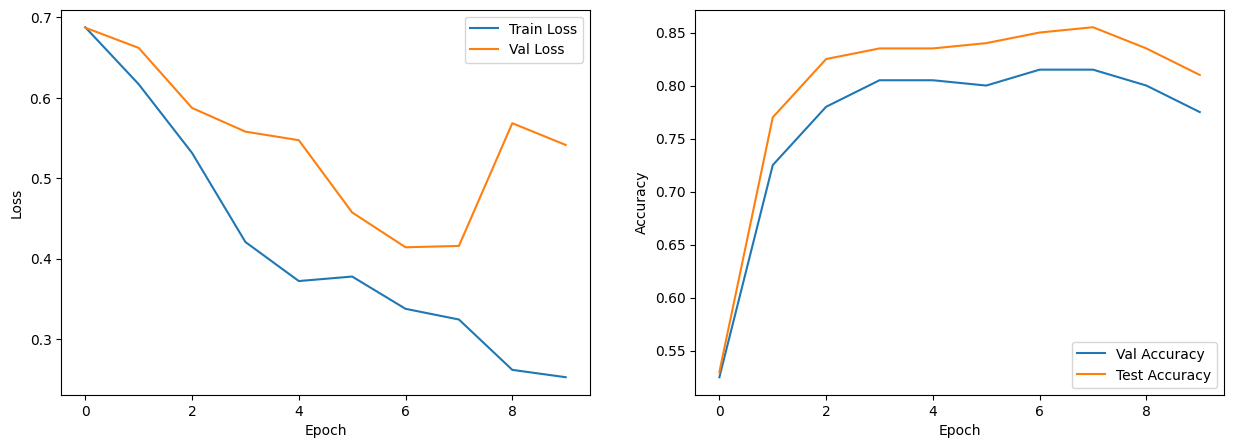

In [29]:
batch_size = 64
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4

# Load all datasets
train_iter = load_data(batch_size=batch_size,
                      num_steps=context_size,
                      dataset=train_data,
                      trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                          num_steps=context_size,
                          dataset=val_data,
                          trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                     num_steps=context_size,
                     dataset=test_data,
                     trainlabels=test_labels)

# Initialize model
model = BatchNorm_ProteinCNN1D(
    vocab_size=20,
    context_size=context_size,
    conv_channels=512,
    use_bias=False
)
model.to(DEVICE)

# Optimizer
optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    for X, y in train_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_losses.append(epoch_train_loss / len(train_iter))
    train_accuracy = train_correct / train_total

    # Validation evaluation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in validation_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            val_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(validation_iter))
    val_accuracies.append(val_correct / val_total)

    # Test evaluation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_losses.append(test_loss / len(test_iter))
    test_accuracies.append(test_correct / test_total)

    # Print metrics
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1]:.4f}, '
          f'Test Acc: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Trying the model on another simulated dataset

In [30]:
datalist2, labellist2 = read(seqfile = "/content/grs34806-deep-learning-project-data/len200_500_n5000nr4.seq",
posfile = "/content/grs34806-deep-learning-project-data/len200_500_n5000nr4.pos")

In [31]:
train_data, val_data, test_data, train_labels, val_labels, test_labels = generate_train_val_test(
    datalist2, labellist2
)

In [32]:
print("Training data size:", len(train_data))
print("Training labels size:", len(train_labels))
print("Validation data size: ", len(val_data))
print("Validation labels size: ", len(val_labels))
print("Test data size:", len(test_data))
print("Test labels size:", len(test_labels))

Training data size: 3000
Training labels size: 3000
Validation data size:  1000
Validation labels size:  1000
Test data size: 1000
Test labels size: 1000


In [33]:
train_iter_newdata = load_data(batch_size = 25, num_steps=200, dataset=train_data, trainlabels=train_labels)
validation_iter_newdata = load_data(batch_size=25, num_steps=200, dataset=val_data, trainlabels=val_labels)
test_iter_newdata = load_data(batch_size= 25, num_steps = 200, dataset = test_data, trainlabels = test_labels)

In [34]:
batch_size = 32
context_size = 200
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4
best_loss =float('inf')


train_iter_newdata = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=train_data,
                       trainlabels=train_labels)

validation_iter_newdata = load_data(batch_size=batch_size,
                            num_steps=context_size,
                            dataset = val_data,
                            trainlabels=val_labels)

test_iter_newdata = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = test_data,
                      trainlabels = test_labels)

# Initializing the model
model = BatchNorm_ProteinCNN1D(
    vocab_size=20,
    context_size=context_size,
    conv_channels=512,
    use_bias = False,
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate,
                              weight_decay=weight_decay)

best_val_acc = 0.0
no_improve = 0
patience = 5 #This defines the number of epochs to wait before stopping
min_delta = 0.001 #The minimum amount of improvement to count as progress

train_losses = []
val_accuracies = []
test_accuracies=[]

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter_newdata:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for X, y in validation_iter_newdata:
          X, y = X.to(DEVICE), y.to(DEVICE)
          logits, _ = model(X, y) #Looking at accuracy only
          val_loss += loss.item()
          preds = (torch.sigmoid(logits) > 0.5).float()
          val_correct += (preds == y).sum().item()
          val_total += y.size(0)

  current_val_acc= val_correct/val_total
  val_accuracies.append(current_val_acc)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]:.4f}')

  # Early stopping check
  if current_val_acc > best_val_acc+min_delta:
      best_val_acc = current_val_acc
      no_improve = 0
      torch.save(model.state_dict(), 'best_model.pth')  # Save best model
  else:
      no_improve += 1
      if no_improve >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}")
          model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Restore best model
          break

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, _ = model(X, y)
        preds = (torch.sigmoid(logits) > 0.5).float()
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

final_test_acc = test_correct / test_total
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

Epoch 1: Train Loss: 6.3101, Validation Accuracy: 0.6100
Epoch 2: Train Loss: 5.6388, Validation Accuracy: 0.7240
Epoch 3: Train Loss: 5.1869, Validation Accuracy: 0.7170
Epoch 4: Train Loss: 4.6901, Validation Accuracy: 0.7300
Epoch 5: Train Loss: 4.4465, Validation Accuracy: 0.7410
Epoch 6: Train Loss: 4.1839, Validation Accuracy: 0.7540
Epoch 7: Train Loss: 3.9625, Validation Accuracy: 0.8260
Epoch 8: Train Loss: 3.7892, Validation Accuracy: 0.8330
Epoch 9: Train Loss: 3.7888, Validation Accuracy: 0.8270
Epoch 10: Train Loss: 3.6324, Validation Accuracy: 0.8340

Final Test Accuracy: 0.4600


Epoch 1: Train Loss: 6.2941, Val Loss: 5.2042, Val Acc: 0.6180, Test Acc: 0.6570
Epoch 2: Train Loss: 5.7245, Val Loss: 4.9555, Val Acc: 0.6600, Test Acc: 0.6340
Epoch 3: Train Loss: 5.0423, Val Loss: 4.3321, Val Acc: 0.8120, Test Acc: 0.7860
Epoch 4: Train Loss: 4.7208, Val Loss: 4.4801, Val Acc: 0.7950, Test Acc: 0.7590
Epoch 5: Train Loss: 4.3598, Val Loss: 4.0567, Val Acc: 0.8270, Test Acc: 0.8070
Epoch 6: Train Loss: 4.2395, Val Loss: 4.0081, Val Acc: 0.8320, Test Acc: 0.8100
Epoch 7: Train Loss: 3.9537, Val Loss: 4.3160, Val Acc: 0.7610, Test Acc: 0.7230
Epoch 8: Train Loss: 3.8277, Val Loss: 3.6611, Val Acc: 0.8260, Test Acc: 0.8100
Epoch 9: Train Loss: 3.7238, Val Loss: 3.5733, Val Acc: 0.8350, Test Acc: 0.8110
Epoch 10: Train Loss: 3.7018, Val Loss: 3.5838, Val Acc: 0.8060, Test Acc: 0.7970


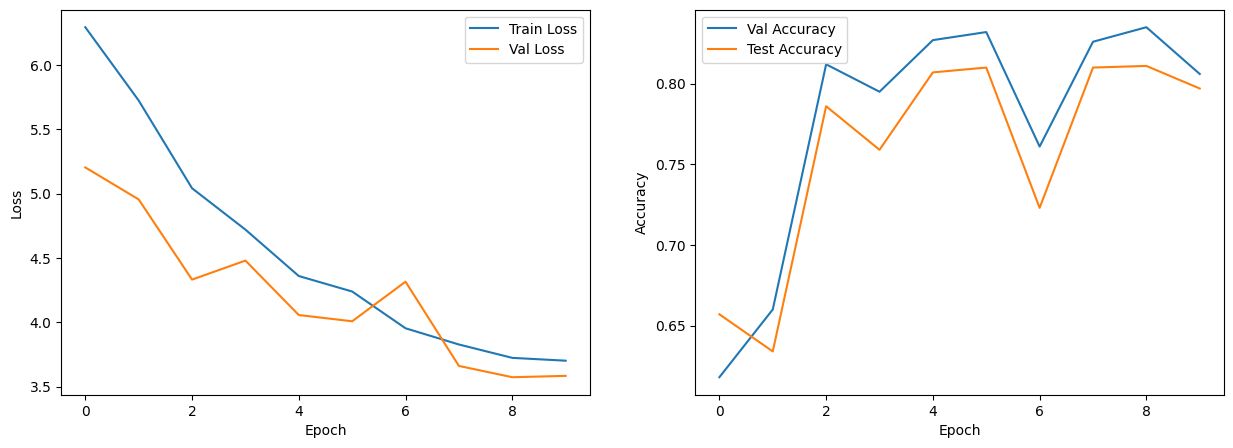

In [35]:
batch_size = 32
context_size = 200
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4

# Load all datasets
train_iter_newdata = load_data(batch_size=batch_size,
                      num_steps=context_size,
                      dataset=train_data,
                      trainlabels=train_labels)

validation_iter_newdata = load_data(batch_size=batch_size,
                          num_steps=context_size,
                          dataset=val_data,
                          trainlabels=val_labels)

test_iter_newdata = load_data(batch_size=batch_size,
                     num_steps=context_size,
                     dataset=test_data,
                     trainlabels=test_labels)

# Initialize model
model = BatchNorm_ProteinCNN1D(
    vocab_size=20,
    context_size=context_size,
    conv_channels=512,
    use_bias=False
)
model.to(DEVICE)

# Optimizer
optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    for X, y in train_iter_newdata:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_losses.append(epoch_train_loss / len(train_iter))
    train_accuracy = train_correct / train_total

    # Validation evaluation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in validation_iter_newdata:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            val_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(validation_iter))
    val_accuracies.append(val_correct / val_total)

    # Test evaluation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_iter_newdata:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_losses.append(test_loss / len(test_iter))
    test_accuracies.append(test_correct / test_total)

    # Print metrics
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1]:.4f}, '
          f'Test Acc: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Increasing batch size from 32 to 64.

In [36]:
batch_size = 64
context_size = 200
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4
best_loss =float('inf')


train_iter_newdata = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=train_data,
                       trainlabels=train_labels)

validation_iter_newdata = load_data(batch_size=batch_size,
                            num_steps=context_size,
                            dataset = val_data,
                            trainlabels=val_labels)

test_iter_newdata = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = test_data,
                      trainlabels = test_labels)

# Initializing the model
model = BatchNorm_ProteinCNN1D(
    vocab_size=20,
    context_size=context_size,
    conv_channels=512,
    use_bias = False,
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate,
                              weight_decay=weight_decay)

best_val_acc = 0.0
no_improve = 0
patience = 5 #This defines the number of epochs to wait before stopping
min_delta = 0.001 #The minimum amount of improvement to count as progress

train_losses = []
val_accuracies = []
test_accuracies=[]

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter_newdata:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for X, y in validation_iter_newdata:
          X, y = X.to(DEVICE), y.to(DEVICE)
          logits, _ = model(X, y) #Looking at accuracy only
          val_loss += loss.item()
          preds = (torch.sigmoid(logits) > 0.5).float()
          val_correct += (preds == y).sum().item()
          val_total += y.size(0)

  current_val_acc= val_correct/val_total
  val_accuracies.append(current_val_acc)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]:.4f}')

  # Early stopping check
  if current_val_acc > best_val_acc+min_delta:
      best_val_acc = current_val_acc
      no_improve = 0
      torch.save(model.state_dict(), 'best_model.pth')  # Save best model
  else:
      no_improve += 1
      if no_improve >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}")
          model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Restore best model
          break

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, _ = model(X, y)
        preds = (torch.sigmoid(logits) > 0.5).float()
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

final_test_acc = test_correct / test_total
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

Epoch 1: Train Loss: 3.1603, Validation Accuracy: 0.6180
Epoch 2: Train Loss: 2.8799, Validation Accuracy: 0.7060
Epoch 3: Train Loss: 2.5751, Validation Accuracy: 0.7910
Epoch 4: Train Loss: 2.3646, Validation Accuracy: 0.8070
Epoch 5: Train Loss: 2.2590, Validation Accuracy: 0.8000
Epoch 6: Train Loss: 2.0650, Validation Accuracy: 0.7760
Epoch 7: Train Loss: 1.9874, Validation Accuracy: 0.7160
Epoch 8: Train Loss: 1.9602, Validation Accuracy: 0.5790
Epoch 9: Train Loss: 1.8115, Validation Accuracy: 0.8030
Early stopping triggered at epoch 9

Final Test Accuracy: 0.4650


Epoch 1: Train Loss: 3.1988, Val Loss: 2.6865, Val Acc: 0.5510, Test Acc: 0.6090
Epoch 2: Train Loss: 2.8799, Val Loss: 2.5409, Val Acc: 0.6260, Test Acc: 0.6650
Epoch 3: Train Loss: 2.6116, Val Loss: 2.2885, Val Acc: 0.7510, Test Acc: 0.7440
Epoch 4: Train Loss: 2.3824, Val Loss: 2.1027, Val Acc: 0.7940, Test Acc: 0.7810
Epoch 5: Train Loss: 2.2554, Val Loss: 2.0688, Val Acc: 0.8250, Test Acc: 0.8010
Epoch 6: Train Loss: 2.0847, Val Loss: 2.0743, Val Acc: 0.8240, Test Acc: 0.7940
Epoch 7: Train Loss: 2.0270, Val Loss: 1.9500, Val Acc: 0.8320, Test Acc: 0.8090
Epoch 8: Train Loss: 1.9641, Val Loss: 2.0316, Val Acc: 0.8230, Test Acc: 0.7980
Epoch 9: Train Loss: 1.9165, Val Loss: 1.9069, Val Acc: 0.8270, Test Acc: 0.8020
Epoch 10: Train Loss: 1.7970, Val Loss: 1.8579, Val Acc: 0.8310, Test Acc: 0.8080


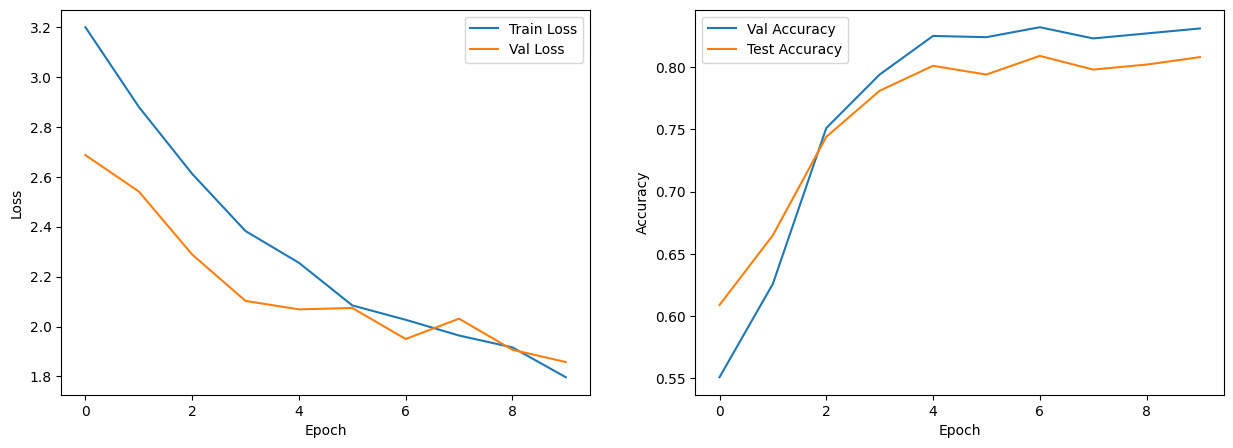

In [37]:
batch_size = 64
context_size = 200
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4

# Load all datasets
train_iter_newdata = load_data(batch_size=batch_size,
                      num_steps=context_size,
                      dataset=train_data,
                      trainlabels=train_labels)

validation_iter_newdata = load_data(batch_size=batch_size,
                          num_steps=context_size,
                          dataset=val_data,
                          trainlabels=val_labels)

test_iter_newdata = load_data(batch_size=batch_size,
                     num_steps=context_size,
                     dataset=test_data,
                     trainlabels=test_labels)

# Initialize model
model = BatchNorm_ProteinCNN1D(
    vocab_size=20,
    context_size=context_size,
    conv_channels=512,
    use_bias=False
)
model.to(DEVICE)

# Optimizer
optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    for X, y in train_iter_newdata:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_losses.append(epoch_train_loss / len(train_iter))
    train_accuracy = train_correct / train_total

    # Validation evaluation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in validation_iter_newdata:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            val_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(validation_iter))
    val_accuracies.append(val_correct / val_total)

    # Test evaluation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_iter_newdata:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_losses.append(test_loss / len(test_iter))
    test_accuracies.append(test_correct / test_total)

    # Print metrics
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1]:.4f}, '
          f'Test Acc: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Increasing the kernel size from 3 to 5 to check for better performance.

In [38]:
class BatchNorm_ProteinCNN1D_differentkernel(nn.Module):
  def __init__(self, vocab_size:int, context_size:int, conv_channels:int=512,
                use_bias:bool=False, dropout_rate = 0.5, lr = 1, weight_decay=1e-4
               ):
      super().__init__()
      assert context_size % 2 == 0, f'Invalid block_size, {context_size} is not an even number'
      self.vocab_size = vocab_size
      self.context_size = context_size
      self.momentum = momentum
      self.cnn = nn.Sequential(
          nn.Conv1d(in_channels=self.vocab_size,
                    out_channels=conv_channels,
                    kernel_size=5,
                    padding='same',
                    bias=use_bias),
          nn.BatchNorm1d(conv_channels),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.Conv1d(in_channels=conv_channels,
                    out_channels=256,
                    kernel_size = 5,
                    padding = 'same',
                    bias = use_bias),
          nn.BatchNorm1d(256),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.Conv1d(in_channels=256,
                    out_channels=128,
                    kernel_size = 5,
                    padding = 'same',
                    bias = use_bias),
          nn.BatchNorm1d(128),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.AdaptiveAvgPool1d(1),
          nn.Flatten(),
          nn.Linear(#in_features = int(128*(self.context_size//8)),
                    in_features = 128,
                    out_features = 256,
                    bias = use_bias),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.Linear(in_features = 256,
                    out_features = 1,
                    bias = use_bias)

      )
  def forward(self, X:torch.tensor, targets: torch.tensor=None) -> tuple[torch.tensor, torch.tensor]:
    logits = self.cnn(X).squeeze(1)
    loss = None if targets is None else F.binary_cross_entropy_with_logits(
        logits, targets.float())
    return logits, loss



In [39]:
batch_size = 64
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4
best_loss =float('inf')


train_iter = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=train_data,
                       trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                            num_steps=context_size,
                            dataset = val_data,
                            trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = test_data,
                      trainlabels = test_labels)

# Initializing the model
model = BatchNorm_ProteinCNN1D_differentkernel(
    vocab_size=20,
    context_size=context_size,
    conv_channels=512,
    use_bias = False
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate,
                              weight_decay=weight_decay)

best_val_acc = 0.0
no_improve = 0
patience = 5 #This defines the number of epochs to wait before stopping
min_delta = 0.001 #The minimum amount of improvement to count as progress

train_losses = []
val_accuracies = []
test_accuracies=[]

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for X, y in validation_iter:
          X, y = X.to(DEVICE), y.to(DEVICE)
          logits, _ = model(X, y) #Looking at accuracy only
          val_loss += loss.item()
          preds = (torch.sigmoid(logits) > 0.5).float()
          val_correct += (preds == y).sum().item()
          val_total += y.size(0)

  current_val_acc= val_correct/val_total
  val_accuracies.append(current_val_acc)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]:.4f}')

  # Early stopping check
  if current_val_acc > best_val_acc+min_delta:
      best_val_acc = current_val_acc
      no_improve = 0
      torch.save(model.state_dict(), 'best_model.pth')  # Save best model
  else:
      no_improve += 1
      if no_improve >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}")
          model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Restore best model
          break

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, _ = model(X, y)
        preds = (torch.sigmoid(logits) > 0.5).float()
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

final_test_acc = test_correct / test_total
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

Epoch 1: Train Loss: 0.6868, Validation Accuracy: 0.6090
Epoch 2: Train Loss: 0.6549, Validation Accuracy: 0.6460
Epoch 3: Train Loss: 0.6246, Validation Accuracy: 0.6120
Epoch 4: Train Loss: 0.6029, Validation Accuracy: 0.6520
Epoch 5: Train Loss: 0.5695, Validation Accuracy: 0.6490
Epoch 6: Train Loss: 0.5479, Validation Accuracy: 0.6470
Epoch 7: Train Loss: 0.5131, Validation Accuracy: 0.6470
Epoch 8: Train Loss: 0.4850, Validation Accuracy: 0.6320
Epoch 9: Train Loss: 0.4824, Validation Accuracy: 0.6330
Early stopping triggered at epoch 9

Final Test Accuracy: 0.6500


Epoch 1: Train Loss: 0.6867, Val Loss: 0.6916, Val Acc: 0.4940, Test Acc: 0.5190
Epoch 2: Train Loss: 0.6603, Val Loss: 0.6539, Val Acc: 0.6190, Test Acc: 0.6260
Epoch 3: Train Loss: 0.6270, Val Loss: 0.6391, Val Acc: 0.6200, Test Acc: 0.6200
Epoch 4: Train Loss: 0.6082, Val Loss: 0.6372, Val Acc: 0.5790, Test Acc: 0.6230
Epoch 5: Train Loss: 0.5660, Val Loss: 0.6635, Val Acc: 0.5430, Test Acc: 0.5860
Epoch 6: Train Loss: 0.5484, Val Loss: 0.6218, Val Acc: 0.6460, Test Acc: 0.6320
Epoch 7: Train Loss: 0.5214, Val Loss: 0.7046, Val Acc: 0.4760, Test Acc: 0.5160
Epoch 8: Train Loss: 0.4929, Val Loss: 0.6190, Val Acc: 0.6390, Test Acc: 0.6360
Epoch 9: Train Loss: 0.4801, Val Loss: 0.7211, Val Acc: 0.5000, Test Acc: 0.5280
Epoch 10: Train Loss: 0.4505, Val Loss: 0.6901, Val Acc: 0.5170, Test Acc: 0.5630


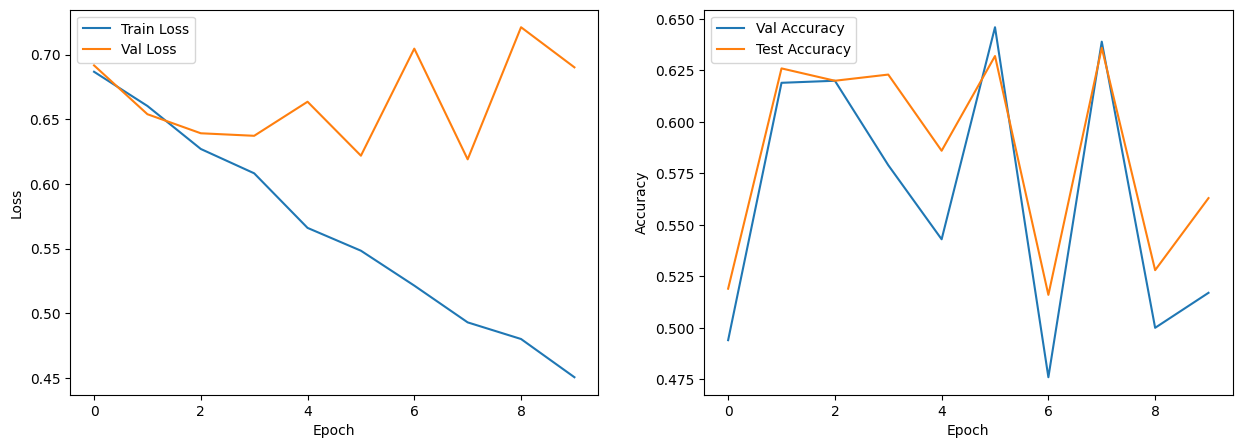

In [40]:
batch_size = 64
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4

# Load all datasets
train_iter_newdata = load_data(batch_size=batch_size,
                      num_steps=context_size,
                      dataset=train_data,
                      trainlabels=train_labels)

validation_iter_newdata = load_data(batch_size=batch_size,
                          num_steps=context_size,
                          dataset=val_data,
                          trainlabels=val_labels)

test_iter_newdata = load_data(batch_size=batch_size,
                     num_steps=context_size,
                     dataset=test_data,
                     trainlabels=test_labels)

# Initialize model
model = BatchNorm_ProteinCNN1D_differentkernel(
    vocab_size=20,
    context_size=context_size,
    conv_channels=512,
    use_bias=False
)
model.to(DEVICE)

# Optimizer
optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    for X, y in train_iter_newdata:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_losses.append(epoch_train_loss / len(train_iter))
    train_accuracy = train_correct / train_total

    # Validation evaluation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in validation_iter_newdata:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            val_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(validation_iter))
    val_accuracies.append(val_correct / val_total)

    # Test evaluation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_iter_newdata:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_losses.append(test_loss / len(test_iter))
    test_accuracies.append(test_correct / test_total)

    # Print metrics
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1]:.4f}, '
          f'Test Acc: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()